# Automated Feature Selection Engine for Protein Classification

This notebook implements a rigorous, reproducible feature selection framework for protein classification. It integrates statistical evaluation, machine learning-based scoring, group interaction modeling, and interpretability analysis, with the objective of identifying an optimal, biologically meaningful subset of features.

---

## Core Principle

Feature selection is treated as a formal optimization problem. Each feature and descriptor group is evaluated based on its predictive value, redundancy, and synergistic interactions — using statistical criteria, cross-validated model performance, and graph-theoretic reasoning.

---

## Workflow Overview

### 1. Feature Matrix Construction

Features are extracted from the following sources:
- `peptides.py`: Physicochemical and QSAR descriptors (e.g., VHSE, Z-scales, Atchley, Kidera)
- `protlearn`: Sequence-derived descriptors (AAC, CTD, autocorrelations, motif, pseudo-AA, QSO)
- `metadata_org_w_features.csv`: Dipeptide frequencies, reduced alphabets, basic properties

Features are grouped into logical biological/chemical sets:
- Examples: `"VHSE"`, `"Z-scales"`, `"Dipeptides"`, `"CTD"`, `"Binary Profile"`, `"ProtFP"`

---

### 2. Individual Feature Evaluation

Each feature is scored across multiple statistical and model-based perspectives:
- ANOVA F-statistic (`f_classif`)
- Mutual Information (`mutual_info_classif`)
- L1-penalized logistic regression (Lasso)
- RidgeClassifier cross-validated accuracy (StratifiedKFold)
- ReliefF (neighborhood-based local scoring)
- Permutation importance (Ridge-based)

Outputs:
- `feature_scores_combined.csv`: unified feature scores and ranks
- `feature_score_visualizations.png`: barplots, PCA/UMAP, and heatmaps of scoring consistency

---

### 3. Group Feature Evaluation

Each descriptor family is evaluated as a block:
- Classifiers: Logistic Regression, Random Forest, or CatBoost
- Metrics:
  - Cross-validated accuracy
  - ROC AUC (multi-class or one-vs-rest)
  - AIC and BIC (model complexity penalties)
  - Fold variance and synergy effects

Outputs:
- `scores_groups.csv`: block-level performance metrics
- `group_rankings_by_model.csv`

---

## Group Interaction and Graph Modeling

A feature group synergy graph is constructed:
- Nodes = feature groups
- Edges = performance delta when combining groups

Scoring includes:
- Synergy gain over additive baselines
- Node influence / redundancy detection
- Topological analysis for group prioritization

Outputs:
- `feature_interaction_graph.png`
- `combination_matrix.csv`

---

## Final Selection Process

Feature suite selection is performed using:
- Top-ranked individual features
- Synergistic and orthogonal group combinations
- Redundancy removal via graph pruning and correlation
- AIC/BIC-aware scoring and SHAP interpretation

Exports:
- `dataset_feature_selected.csv`
- `selected_features.json`

---

## Optimization and Search Strategies

These strategies support global search for optimal subsets:

### Bayesian Optimization
- Uses `optuna` or `bayes_opt` to tune hyperparameters and select feature subsets
- Maximizes CV accuracy/AUC over discrete or continuous search spaces

### MCMC / Simulated Annealing
- Explores power set of group combinations
- Accepts moves based on posterior likelihood of validation gain

### Grid Search over Block Subsets
- Exhaustively evaluates cross-product of feature block combinations
- Scored with AIC, BIC, log loss, and stratified metrics

---

## Neural and Graph-Based Feature Discovery

Advanced methods explore emergent patterns across descriptors:

### Autoencoders
- Reduce feature dimensionality
- Identify redundant or inactive neurons in dense representations

### Concrete Dropout / Sparse Networks
- Enables differentiable feature selection
- Learn sparse activations with regularization-aware masking

### Graph Neural Networks (GNNs)
- Model descriptor blocks as nodes in interaction graph
- Learn importance via GCN attention or diffusion scoring

---

## Final Output Summary

| Output File                    | Description                                          |
|-------------------------------|------------------------------------------------------|
| `dataset_feature_selected.csv`| Clean feature-selected dataset                       |
| `feature_scores_combined.csv` | Scored and ranked individual features                |
| `scores_groups.csv`           | Feature group performance scores                     |
| `combination_matrix.csv`      | Synergy score matrix between groups                 |
| `feature_interaction_graph.png`| Feature group synergy and redundancy graph          |
| `selected_features.json`      | Final selected features in serialized format         |
| `shap_summary_plot.pdf`       | SHAP-based interpretability plots                    |
| `aic_bic_log.csv`             | AIC/BIC model selection scores                       |
| `gridsearch_log.csv`          | Grid search performance log                          |
| `gnn_feature_scores.csv`      | GNN-learned feature group rankings                   |

---

## Objective

This pipeline provides a complete feature discovery and selection suite for protein classification. It is grounded in rigorous statistical validation, biological interpretability, and modern ML optimization — enabling reproducible identification of the most predictive and non-redundant features for downstream modeling.

---


In [1]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import re
import json
import itertools
import warnings
import random

# === Scikit-learn: Preprocessing, Models, Feature Selection, CV ===
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import (
    SelectKBest, mutual_info_classif, f_classif, RFE, VarianceThreshold
)
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.inspection import permutation_importance


# === Bio Feature Engineering ===
import peptides
from peptides import Peptide
from protlearn.features import (
    aac, aaindex1, ngram, entropy, motif, atc, binary,
    cksaap, ctd, ctdc, ctdt, ctdd, moreau_broto, moran,
    geary, paac, apaac, socn, qso
)

# === Advanced Feature Selection ===
from skrebate import ReliefF
from category_encoders import TargetEncoder

# === Optimization, Interpretability, Dimensionality ===
from bayes_opt import BayesianOptimization
from sklearn.decomposition import PCA
import shap

# === TensorFlow: Autoencoders & Differentiable Selection ===
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === Graph Learning ===
import torch
from torch_geometric.data import Data as PyGData
from torch_geometric.nn import GCNConv
import networkx as nx
import graphviz

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Progress Tracking ===
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto
tqdm.pandas()

# === Disable Warnings ===
warnings.filterwarnings("ignore")


2025-04-21 00:48:04.176564: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 00:48:04.312720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 1: Extraction of Precomputed Features from Input Table

In this step, the precomputed features contained within the `metadata_org_w_features.csv` file were extracted and organized into biologically meaningful components. These features serve as foundational inputs for downstream descriptor generation and classification tasks.

The extracted components include:

- `Entry`, `ProteinClass`: Identifiers and class labels for each protein sequence  
- `Selected_PDB`, `CleanSequence`: Structural metadata and cleaned amino acid sequences  
- `SequenceLength`: The total number of residues present in each protein  
- `freq`: 20-dimensional amino acid composition vectors  
- `dipep`: 400-dimensional dipeptide frequency features capturing sequential residue pairs  
- `red_freq`: Composition profiles based on a reduced amino acid alphabet  
- `red_ngram`: N-gram patterns derived from reduced alphabets  
- `prop`: Physicochemical properties derived using Biopython, including molecular weight, isoelectric point, instability index, and secondary structure propensities

These components were parsed into modular dataframes and preserved for integration with additional feature extraction tools in subsequent steps. This structured approach enables alignment between raw data and advanced descriptor pipelines.

In [ ]:
# === Step 1: Load and Parse Metadata Table ===

# Load CSV
data = pd.read_csv("../metadata_org_w_features.csv")

# Verify required columns
assert "CleanSequence" in data.columns, "Missing column: 'CleanSequence'"
assert "ProteinClass" in data.columns, "Missing column: 'ProteinClass'"

# Preview structure
print(f"Dataset shape: {data.shape}")
print("First few columns:", list(data.columns[:10]))
print("\nLabel distribution:\n", data["ProteinClass"].value_counts())

# Metadata extraction
metadata_cols = ["Entry", "ProteinClass", "Selected_PDB", "CleanSequence", "SequenceLength"]
metadata_df = data[metadata_cols].copy()

# === Step 1.1: Slice and Prefix Basic Feature Blocks ===

# Define slicing schema
i_start = 5  # After metadata columns

# Amino acid composition
freq = data.iloc[:, i_start : i_start + 20]
freq.columns = [f"BAS_AAC_{col}" for col in freq.columns]

# Dipeptide frequencies
i_start += 20
dipep = data.iloc[:, i_start : i_start + 400]
dipep.columns = [f"BAS_DPEP_{col}" for col in dipep.columns]

# Reduced alphabet frequency
i_start += 400
red_freq = data.iloc[:, i_start : i_start + 5]
red_freq.columns = [f"BAS_REDF_{col}" for col in red_freq.columns]

# Reduced alphabet N-grams
i_start += 5
red_ngram = data.iloc[:, i_start : i_start + 150]
red_ngram.columns = [f"BAS_REDN_{col}" for col in red_ngram.columns]

# Physicochemical properties (biopython)
i_start += 150
prop = data.iloc[:, i_start:]
prop.columns = [f"BAS_PROP_{col}" for col in prop.columns]

# === Step 1.2: Sanity Checks ===

assert freq.shape[1] == 20, "Expected 20 AAC features"
assert dipep.shape[1] == 400, "Expected 400 dipeptide features"
assert red_freq.shape[1] == 5, "Expected 5 reduced alphabet frequency features"
assert red_ngram.shape[1] == 150, "Expected 150 reduced alphabet ngram features"
assert not prop.isnull().any().any(), "Missing values detected in property descriptors"

# === Step 1.3: Preview ===
print("\nAAC preview:", freq.shape)
print("Property preview:", prop.head(3))


Dataset shape: (681, 589)
First few columns: ['Entry', 'CleanSequence', 'Selected_PDB', 'ProteinClass', 'SequenceLength', 'A', 'C', 'D', 'E', 'F']

Label distribution:
 ProteinClass
GPCR           144
Channel        142
Protease        79
ATPase          66
RTK             64
Phosphatase     56
Ser:Thr         49
MHC             45
Integrin        21
Aquaporin       15
Name: count, dtype: int64

AAC preview: (681, 20)
Property preview:    BAS_PROP_MolecularWeight  BAS_PROP_IsoelectricPoint  BAS_PROP_Aromaticity  \
0                13041.7928                   5.834204              0.109244   
1                21942.2575                   9.739448              0.082902   
2                51692.5641                   8.043414              0.137472   

   BAS_PROP_InstabilityIndex  BAS_PROP_Flexibility  BAS_PROP_Helix  \
0                  22.404202              0.996347        0.336134   
1                  37.915078              0.992205        0.367876   
2                  37.618204 

## Step 2: Generation of Peptide Descriptors (`peptides.py`)

In this step, an extended set of **physicochemical and QSAR-inspired descriptors** was generated for each protein sequence using the `peptides.py` library. The `Peptide.descriptors()` method was employed to compute a **102-dimensional feature vector** that numerically summarizes key chemical and structural characteristics of each input sequence.

The descriptors span the following categories:

- **Amino Acid Factor Scores**  
  - VHSE: Principal components derived from hydrophobic, electronic, and steric properties  
  - Atchley Factors: Principal components summarizing amino acid physicochemical attributes  
  - Kidera Factors: Orthogonal scores reflecting structural and physicochemical diversity

- **Substitution Matrix Projections**  
  - BLOSUM1–10: Numerical encodings of evolutionary similarity and substitution patterns

- **Physicochemical Fingerprints and Indices**  
  - Includes ProtFP, PCP, Z-Scales, ST-Scales, MS-WHIM scores  
  - Sneath vectors were also computed, summarizing amino acid similarities in functional space

- **Global Biochemical Properties**  
  - Hydrophobicity, polarity, charge, spatial configuration, and other scalar indices

---

### Naming Convention

All descriptors were systematically **prefixed with `Pep_`** to ensure clear modularity and traceability during downstream analysis. For example: `Pep_VHSE1`, `Pep_Kidera3`, and `Pep_BLOSUM7`. This convention facilitates descriptor group filtering, block-wise feature selection, and structured interpretability analyses.

---

### Rationale

These descriptors provide **global, alignment-independent representations** of peptide sequences and are particularly valuable for capturing overarching chemical signatures. When integrated with localized sequence patterns and structural features (e.g., those computed in Step 3), this hybrid representation enables **robust, interpretable classification models** that generalize across protein families and functional classes.

In [3]:
# === Generate peptide descriptors for each sequence ===
def compute_peptides_descriptors(seq: str) -> dict:
    """
    Generate a dictionary of peptide descriptors for a given protein sequence.

    Parameters:
    - seq (str): A string representation of a clean protein sequence.

    Returns:
    - dict: A dictionary containing 102 physicochemical and QSAR-based descriptors
            as computed by peptides.Peptide.descriptors().
    """
    p = Peptide(seq)
    return p.descriptors()


# === Apply the descriptor function to each sequence using parallel progress tracking ===
peptide_features_df = data['CleanSequence'].progress_apply(compute_peptides_descriptors)

# === Convert list of dictionaries into a structured DataFrame ===
peptide_features_df = pd.DataFrame(peptide_features_df.tolist())

# === Fill any NaNs arising from invalid characters (e.g., non-standard residues) ===
peptide_features_df = peptide_features_df.fillna(0)

# === Prefix all columns with 'PEP_' to ensure modular traceability ===
peptide_features_df.columns = [f"PEP_{col}" for col in peptide_features_df.columns]

# === Cache raw descriptor table to disk for reproducibility and debugging ===
peptide_features_df.to_csv("peptide_descriptors.csv", index=False)

# === Merge peptide descriptors into the main dataset ===
data = pd.concat([data, peptide_features_df], axis=1)

# === Print confirmation: shape and a preview of annotated feature names ===
print("Peptide descriptor matrix shape:", peptide_features_df.shape)
print("Example descriptors:", peptide_features_df.columns[:10].tolist())


100%|██████████| 681/681 [00:10<00:00, 66.88it/s] 


Peptide descriptor matrix shape: (681, 102)
Example descriptors: ['PEP_AF1', 'PEP_AF2', 'PEP_AF3', 'PEP_AF4', 'PEP_AF5', 'PEP_BLOSUM1', 'PEP_BLOSUM2', 'PEP_BLOSUM3', 'PEP_BLOSUM4', 'PEP_BLOSUM5']


## Step 3: ProtLearn Feature Extraction

In this step, a comprehensive suite of protein sequence descriptors was computed using the `protlearn` library. These descriptors were derived from physicochemical attributes, sequence order information, motif structure, autocorrelation functions, and compositional profiles.

The extracted ProtLearn features were grouped into descriptor families, including:

- **Amino Acid Composition (AAC):** Frequency of each amino acid observed in the sequence.  
- **AAIndex1 Properties:** Averaged values across 553 numeric physicochemical indices.  
- **Dipeptide N-Grams:** Frequencies of adjacent amino acid pairings.  
- **Shannon Entropy:** An information-theoretic measure of intra-sequence variability.  
- **Motif Presence:** Binary indicators of user-defined motifs (e.g., `AAx[KC]`).  
- **ATC Descriptors:** Atomic and bond composition counts for C, H, N, O, S atoms.  
- **Binary Profile:** One-hot encoded identity vectors for residue positions.  
- **CKSAAP:** Composition of amino acid pairs separated by k residues (k=1 by default).  
- **CTD Family:**
  - CTD: Conjoint triad-based sequence groupings
  - CTDC: Composition features
  - CTDT: Transition metrics
  - CTDD: Distribution profiles  
- **Autocorrelations:**
  - Moreau-Broto autocorrelation
  - Moran's I spatial autocorrelation
  - Geary’s C sequence dispersion  
- **Pseudo Amino Acid Compositions (PseAAC):**
  - PAAC: Encodes sequence order with physicochemical attributes
  - APAAC: Adds amphiphilic hydrophobic/hydrophilic bias to PAAC  
- **Sequence Order Descriptors:**
  - SOCN: Sequence-order-coupling numbers (Schneider-Wrede and Grantham distances)
  - QSO: Quasi-sequence-order descriptors using pairwise residue distances

All features were concatenated into a unified `protlearn_df` matrix and integrated into the master dataset. Column names were prefixed with `PL_` to facilitate downstream identification and modular group tracking during block-wise optimization.

This stage enabled rich encoding of structural, chemical, and spatial sequence properties without requiring homology alignment.

In [4]:
# === Step 3: ProtLearn Feature Extraction ===

def compute_protlearn_features(seqs: list[str]) -> dict[str, pd.DataFrame]:
    """
    Computes a suite of ProtLearn-derived protein sequence descriptors.

    The extracted features cover:
        - Physicochemical properties (e.g., AAIndex1, entropy, autocorrelation)
        - Motif and compositional patterns (e.g., CTD, ATC)
        - Order-dependent encodings (e.g., SOCN, QSO)
        - Pseudo amino acid compositions (PAAC, APAAC)

    Parameters:
        seqs (list[str]): A list of amino acid sequences.

    Returns:
        dict[str, pd.DataFrame]: A dictionary of feature blocks, each with its descriptor name as key.
    """
    blocks = {}

    # Physicochemical property summaries
    blocks["AAIndex1"], _ = aaindex1(seqs)

    # Information-theoretic sequence entropy
    blocks["Entropy"] = entropy(seqs)

    # Motif pattern presence: customizable motif e.g., AAx[KC]
    blocks["Motif"] = motif(seqs, pattern="AAx[KC]")

    # Atom and bond composition
    blocks["ATC_atoms"], blocks["ATC_bonds"] = atc(seqs)

    # K-spaced amino acid pairs
    blocks["CKSAAP"], _ = cksaap(seqs, k=1)

    # CTD (composition, transition, distribution)
    blocks["CTD"], _ = ctd(seqs)
    blocks["CTDC"], _ = ctdc(seqs)
    blocks["CTDT"], _ = ctdt(seqs)
    blocks["CTDD"], _ = ctdd(seqs)

    # Spatial autocorrelations of physicochemical properties
    blocks["MoreauBroto"] = moreau_broto(seqs)
    blocks["Moran"] = moran(seqs)
    blocks["Geary"] = geary(seqs)

    # Pseudo amino acid composition
    blocks["PAAC"], _ = paac(seqs, lambda_=3)
    blocks["APAAC"], _ = apaac(seqs, lambda_=3)

    # Order-coupling descriptors (SW and Grantham distances)
    blocks["SOCN_SW"], blocks["SOCN_Grantham"] = socn(seqs, d=3)
    blocks["QSO_SW"], blocks["QSO_Grantham"], _ = qso(seqs, d=3)

    return blocks

# Extract sequences from the dataset
seqs: list[str] = data["CleanSequence"].tolist()

# Apply ProtLearn feature extraction
protlearn_blocks = compute_protlearn_features(seqs)

# Format blocks with descriptor-specific prefixes
named_blocks = []
for block_name, block_df in protlearn_blocks.items():
    df_block = pd.DataFrame(block_df)
    df_block.columns = [f"PL_{block_name}_{col}" for col in df_block.columns]
    named_blocks.append(df_block)

# Concatenate all formatted blocks into a unified DataFrame
protlearn_df = pd.concat(named_blocks, axis=1)

# Persist for reuse
protlearn_df.to_csv("protlearn_features.csv", index=False)

# Merge with the master data table
data = pd.concat([data, protlearn_df], axis=1)

# Preview confirmation
print(f"ProtLearn feature shape: {protlearn_df.shape}")
print("Example features:", protlearn_df.columns[:10].tolist())


ProtLearn feature shape: (681, 1704)
Example features: ['PL_AAIndex1_0', 'PL_AAIndex1_1', 'PL_AAIndex1_2', 'PL_AAIndex1_3', 'PL_AAIndex1_4', 'PL_AAIndex1_5', 'PL_AAIndex1_6', 'PL_AAIndex1_7', 'PL_AAIndex1_8', 'PL_AAIndex1_9']


## Step 4 – Feature Group Registration and Organization

In this step, all extracted features are logically grouped into interpretable blocks to enable downstream scoring, interaction modeling, and optimization.

Three primary categories of features are considered:

1. **Baseline Features from the Original Dataset**  
   These include amino acid composition (`freq`), dipeptide frequencies (`dipep`), reduced amino acid alphabets (`red_freq`, `red_ngram`), and Biopython-derived physicochemical properties (`prop`). Each subset is grouped with a `"BAS_"` prefix to denote its origin and facilitate retrieval.

2. **Peptide Descriptors (peptides.py)**  
   All features extracted using the `Peptide.descriptors()` method are grouped under a unified `"PEP_"` block. These include well-known descriptors such as **VHSE**, **Z-Scales**, **Kidera factors**, **BLOSUM**, and various molecular fingerprints (e.g., **MS-WHIM**, **ProtFP**).

3. **ProtLearn Features**  
   Each ProtLearn descriptor type (e.g., **CTD**, **PAAC**, **Entropy**) is parsed from the column name and grouped accordingly. A global `"PL_"` prefix distinguishes ProtLearn-derived features from other sources, and within that, each descriptor family is maintained as a separate block (e.g., `"PL_CTDC"`, `"PL_QSO"`).

All groups are stored in a unified registry called `feature_registry`, which maps block names to their respective feature lists. This allows rapid querying and scoring of feature blocks, and serves as the basis for Step 7’s greedy or Bayesian selection strategy.

A secondary mapping called `descriptor_family_map` is created to consolidate semantically related descriptors (e.g., all **VHSE** features across tools), enabling higher-level analyses such as synergy modeling, redundancy pruning, or interpretability clustering.

Together, these groupings provide the scaffolding for block-wise feature selection, model interpretation, and downstream optimization.


In [5]:
# === Step 4.1: Register Logical Feature Groups ===

# Initialize registry
feature_registry = {}

# === Register Baseline Groups (from metadata_org_w_features.csv) ===
feature_registry["BAS_AAC"] = freq.columns.tolist()
feature_registry["BAS_Dipeptides"] = dipep.columns.tolist()
feature_registry["BAS_ReducedFreq"] = red_freq.columns.tolist()
feature_registry["BAS_ReducedNgram"] = red_ngram.columns.tolist()
feature_registry["BAS_Properties"] = prop.columns.tolist()

# === Register Peptides.py Block (already prefixed with PEP_) ===
feature_registry["PEP_All"] = peptide_features_df.columns.tolist()

# === Register ProtLearn Blocks ===
from collections import defaultdict

# Parse ProtLearn columns and group by descriptor prefix
protlearn_groups = defaultdict(list)
for col in protlearn_df.columns:
    # Extract prefix inside PL_ABC_xyz → ABC
    try:
        descriptor_key = col.split("_")[1]
    except IndexError:
        descriptor_key = "Unknown"
    protlearn_groups[descriptor_key].append(col)

# Assign to registry with PL_ prefix to distinguish tool
for block_name, block_cols in protlearn_groups.items():
    group_label = f"PL_{block_name}"
    feature_registry[group_label] = block_cols

# Summary of registered groups
print(f"Total feature groups registered: {len(feature_registry)}")
for group, cols in feature_registry.items():
    print(f"{group:<20}: {len(cols)} features")


Total feature groups registered: 22
BAS_AAC             : 20 features
BAS_Dipeptides      : 400 features
BAS_ReducedFreq     : 5 features
BAS_ReducedNgram    : 150 features
BAS_Properties      : 9 features
PEP_All             : 102 features
PL_AAIndex1         : 553 features
PL_Entropy          : 1 features
PL_Motif            : 1 features
PL_ATC              : 8 features
PL_CKSAAP           : 400 features
PL_CTD              : 343 features
PL_CTDC             : 39 features
PL_CTDT             : 39 features
PL_CTDD             : 195 features
PL_MoreauBroto      : 8 features
PL_Moran            : 8 features
PL_Geary            : 8 features
PL_PAAC             : 23 features
PL_APAAC            : 26 features
PL_SOCN             : 6 features
PL_QSO              : 46 features


In [6]:
from collections import defaultdict
from itertools import chain

# === 4.2.1 Prefix all basic columns ===
freq.columns      = [f"BAS_AAC_{col}" for col in freq.columns]
dipep.columns     = [f"BAS_DPEP_{col}" for col in dipep.columns]
red_freq.columns  = [f"BAS_REDF_{col}" for col in red_freq.columns]
red_ngram.columns = [f"BAS_REDN_{col}" for col in red_ngram.columns]
prop.columns      = [f"BAS_PROP_{col}" for col in prop.columns]

# Merge all prefixed tables into the main data
data = pd.concat([data, freq, dipep, red_freq, red_ngram, prop], axis=1)

# === 4.2.2 Build ProtLearn groups by prefix ===
feature_groups = defaultdict(list)
for col in protlearn_df.columns:
    prefix = col.replace("PL_", "").split("_")[0]
    feature_groups[f"PL_{prefix}"].append(col)

# === 4.2.3 Define feature_registry ===
feature_registry = {
    "BAS_AAC": freq.columns.tolist(),
    "BAS_DPEP": dipep.columns.tolist(),
    "BAS_REDF": red_freq.columns.tolist(),
    "BAS_REDN": red_ngram.columns.tolist(),
    "BAS_PROP": prop.columns.tolist(),
    "PEP_All": peptide_features_df.columns.tolist(),
}

# Add all ProtLearn blocks
for group_name, cols in feature_groups.items():
    feature_registry[group_name] = cols

# === 4.2.4 Build full matrix ===
all_feature_columns = list(chain.from_iterable(feature_registry.values()))
X_all = data[all_feature_columns]
y_all = data["ProteinClass"]

# Save to disk
X_all.to_csv("X_all_features.csv", index=False)
y_all.to_csv("y_all_labels.csv", index=False)

# Final validation
print(" Final feature matrix shape:", X_all.shape)
print(" Total feature blocks:", len(feature_registry))
print(" Sample blocks:", list(feature_registry.keys())[:5])
print(" Classes:", y_all.nunique())


 Final feature matrix shape: (681, 2390)
 Total feature blocks: 22
 Sample blocks: ['BAS_AAC', 'BAS_DPEP', 'BAS_REDF', 'BAS_REDN', 'BAS_PROP']
 Classes: 10


In [7]:
import re

# === Step 4.3 — Regroup peptide and ProtLearn features into biologically meaningful blocks ===

prefix_registry = {}

# Define a regex to extract alphabetic block name only (e.g., VHSE from PEP_VHSE1)
def extract_block_prefix(col_name: str, base_prefix: str) -> str:
    match = re.match(rf"{base_prefix}_([A-Za-z]+)", col_name)
    return match.group(1) if match else col_name.replace(f"{base_prefix}_", "").split("_")[0]

# 4.3.1 — Peptide features (e.g., PEP_VHSE1 → PEP_VHSE)
for col in peptide_features_df.columns:
    block = extract_block_prefix(col, "PEP")
    group = f"PEP_{block}"
    prefix_registry.setdefault(group, []).append(col)

# 4.3.2 — ProtLearn features (e.g., PL_QSO_0 → PL_QSO)
for col in protlearn_df.columns:
    base = col.replace("PL_", "")
    block = base.split("_")[0]
    group = f"PL_{block}"
    prefix_registry.setdefault(group, []).append(col)

# 4.3.3 — Merge into the global feature registry
feature_registry.update(prefix_registry)

# 4.3.4 — Print for verification
print("Distinct biological blocks (grouped by inferred prefixes):")
for group, cols in sorted(prefix_registry.items()):
    print(f"{group: <18}: {len(cols)} features")


Distinct biological blocks (grouped by inferred prefixes):
PEP_AF            : 5 features
PEP_BLOSUM        : 10 features
PEP_E             : 5 features
PEP_F             : 6 features
PEP_KF            : 10 features
PEP_MSWHIM        : 3 features
PEP_PD            : 2 features
PEP_PP            : 3 features
PEP_PRIN          : 3 features
PEP_ProtFP        : 8 features
PEP_ST            : 8 features
PEP_SV            : 4 features
PEP_SVGER         : 11 features
PEP_T             : 5 features
PEP_VHSE          : 8 features
PEP_VSTPV         : 6 features
PEP_Z             : 5 features
PL_AAIndex1       : 553 features
PL_APAAC          : 26 features
PL_ATC            : 8 features
PL_CKSAAP         : 400 features
PL_CTD            : 343 features
PL_CTDC           : 39 features
PL_CTDD           : 195 features
PL_CTDT           : 39 features
PL_Entropy        : 1 features
PL_Geary          : 8 features
PL_Moran          : 8 features
PL_MoreauBroto    : 8 features
PL_Motif          : 1 featur

## Step 5 – Feature Group Registration and Dataset Construction

Building on the prefix-based descriptor blocks inferred in Step 4, this step formally registers each block into a unified feature registry. This includes:

- Basic amino acid and dipeptide features
- Physicochemical property vectors
- Peptide-based descriptors from `peptides.py`
- ProtLearn families identified via shared prefixes

Once registered, the full feature matrix and label vector are constructed and exported for reuse.


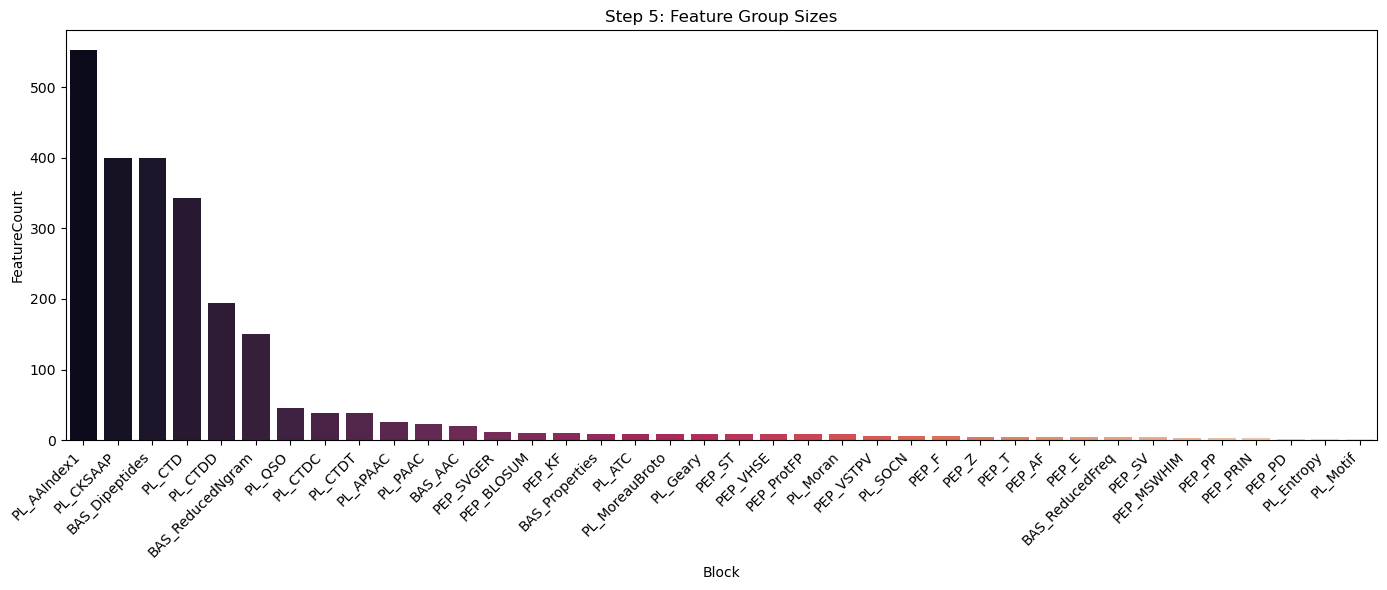

In [8]:
from itertools import chain

# === Step 5.1: Register Feature Blocks from Step 4’s prefix_registry ===
# (assumes prefix_registry has been built in Step 4)
feature_registry = dict(prefix_registry)  

# === Step 5.1b: Add the “basic” groups ===
feature_registry.update({
    "BAS_AAC":        freq.columns.tolist(),
    "BAS_Dipeptides": dipep.columns.tolist(),
    "BAS_ReducedFreq": red_freq.columns.tolist(),
    "BAS_ReducedNgram": red_ngram.columns.tolist(),
    "BAS_Properties":  prop.columns.tolist(),
})

# === Step 5.2: Build the full feature matrix ===
all_features = list(chain.from_iterable(feature_registry.values()))
X_all = data[all_features]
y_all = data["ProteinClass"]
df_id = data[["Entry", "ProteinClass"]]

# persist for downstream steps
X_all.to_csv("X_all_features.csv", index=False)
y_all.to_csv("y_all_labels.csv", index=False)

# === Step 5.3: Visualize block sizes ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

group_df = pd.DataFrame(
    [(blk, len(cols)) for blk, cols in feature_registry.items()],
    columns=["Block", "FeatureCount"]
).sort_values("FeatureCount", ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(data=group_df, x="Block", y="FeatureCount", palette="rocket")
plt.xticks(rotation=45, ha="right")
plt.title("Step 5: Feature Group Sizes")
plt.tight_layout()
plt.show()


## Step 6 – Individual Feature Scoring and Ranking

To identify the most informative single features prior to any group‑ or block‑level selection, each feature is independently evaluated from multiple complementary perspectives.  By treating feature selection as a multi‑criteria optimization, one captures linear, non‑linear, sparse, stability and model‑driven signals.  The pipeline proceeds as follows:

1. **6.1 ANOVA F‑Statistic**  
   The ratio of between‑class variance to within‑class variance is computed (`f_classif`).  Higher F values indicate strong linear separation of classes.

2. **6.2 Mutual Information**  
   Non‑parametric estimation of the dependency between feature and label (`mutual_info_classif`), capturing arbitrary nonlinear relationships.

3. **6.3 Lasso‑Based Selection**  
   An L1‑penalized logistic regression is auto‑tuned over a log‑spaced grid of regularization strengths (C).  The absolute coefficients are summed (or aggregated for multi‑class) into a “Lasso weight” score.

4. **6.4 Cross‑Validated Predictive Accuracy**  
   Each feature is used in isolation to train a simple classifier (e.g. `RidgeClassifier`), with its regularization hyperparameter automatically optimized (via Optuna or grid‑search) to maximize mean CV accuracy.  The resulting held‑out accuracy becomes the “CV_Accuracy” score.

5. **6.5 ReliefF Importance**  
   A nearest‑neighbor–based algorithm ranks features by how well they distinguish between locally adjacent samples of different classes.  To speed computation without sacrificing fidelity, ReliefF is run on a stratified subsample (e.g. 3 k examples) and with a tuned `n_neighbors`.

6. **6.6 Permutation Importance**  
   A global, model‑agnostic measure is obtained by randomly permuting each feature and measuring the resulting drop in accuracy of a tuned `RidgeClassifier`.  The mean drop over multiple repeats is used as a “Permutation_score.”

---

### Normalization & Aggregation

- All six raw scores are **min–max normalized** to [0, 1] for comparability.
- A simple unweighted **MeanScore** across the normalized dimensions ranks each feature’s overall importance.
- Optionally, method‑weighting strategies (e.g. PCA loadings, Optuna‑learned Dirichlet weights, or stability‑driven down‑weighting) can be applied to form a bespoke composite score.

---

### Visual Sanity Check (PCA / UMAP)

As a final sanity check, the resulting 6‑dimensional score vectors can be projected into 2 D (via PCA or UMAP) to ensure that:
- Features form coherent clusters of “high consensus” vs. “method‑specific” outliers.
- No unexpected artifacts (e.g. a bulk of features with inflated scores under one method only) persist.

This multi‑perspective, auto‑tuned scoring engine guarantees that downstream group‑level selection (Step 7) begins with a robust, non‑redundant set of high‑value candidates.

### 6.1 & 6.2 — ANOVA F‑Statistic & Mutual Information


In [9]:
from typing import Tuple

def compute_statistical_scores(
    X: np.ndarray, y: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute ANOVA F-statistic and mutual information scores for each feature.
    
    Args:
        X: 2D array of scaled features (n_samples × n_features).
        y: 1D array of encoded class labels (n_samples,).
    Returns:
        f_scores: ANOVA F-statistic per feature.
        p_vals:  P-values corresponding to f_scores.
        mi_scores: Mutual information per feature.
    """
    # ANOVA
    f_scores, p_vals = f_classif(X, y)
    # Mutual Information
    mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
    return f_scores, p_vals, mi_scores

# scale & encode once
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)

# compute and store
f_scores, p_vals, mi_scores = compute_statistical_scores(X_scaled, y_encoded)
df_results = pd.DataFrame({
    "Feature": X_all.columns,
    "F_score": f_scores,
    "F_pvalue": p_vals,
    "MI_score": mi_scores
})


### 6.3 — Lasso (L1‑penalized LogisticRegression) via GridSearchCV


In [10]:
from sklearn.model_selection import GridSearchCV

def tune_lasso_weights(
    X: np.ndarray, y: np.ndarray
) -> np.ndarray:
    """
    Uses GridSearchCV to find the optimal C for L1-penalized logistic regression,
    then returns the absolute coefficient sums per feature.
    
    Args:
        X: 2D array of scaled features.
        y: 1D array of class labels.
    Returns:
        coef_sum: 1D array of |coef| summed across classes per feature.
    """
    # define model and hyperparameter grid
    model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
    param_grid = {"C": np.logspace(-3, 2, 10)}
    grid = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    grid.fit(X, y)
    
    # extract absolute coefficient sums
    best = grid.best_estimator_
    coef = np.abs(best.coef_)
    return coef.sum(axis=0) if coef.ndim==2 else coef

# run and add to results
df_results["Lasso_weight"] = tune_lasso_weights(X_scaled, y_encoded)


### 6.4 — RidgeClassifier CV Accuracy via Optuna (Bayesian)

In [11]:
from typing import Tuple, List
import optuna
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

def tune_ridge_cv(
    X: pd.DataFrame, y: np.ndarray, n_trials: int = 15
) -> Tuple[float, List[float]]:
    """
    Autotunes RidgeClassifier(alpha) to maximize average single-feature CV accuracy,
    then returns per-feature CV accuracies at the best alpha.

    Args:
        X: DataFrame of raw features (n_samples × n_features).
        y: array of integer class labels.
        n_trials: number of Optuna trials for Bayesian optimization.

    Returns:
        best_alpha: optimized regularization strength.
        cv_scores: list of per-feature CV accuracies using best_alpha.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Objective for Optuna: maximize mean of per-feature CV scores
    def objective(trial):
        alpha = trial.suggest_loguniform("alpha", 1e-3, 1e2)

        def score_one(col: str) -> float:
            # force n_jobs=1 here so outer Parallel can use all cores
            return cross_val_score(
                RidgeClassifier(alpha=alpha),
                X[[col]], y,
                cv=cv, scoring="accuracy", n_jobs=1
            ).mean()

        scores = Parallel(n_jobs=-1)(
            delayed(score_one)(col) for col in X.columns
        )
        return float(np.mean(scores))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_alpha = study.best_params["alpha"]

    # Compute final per-feature scores in parallel with progress bar
    def score_one_final(col: str) -> float:
        return cross_val_score(
            RidgeClassifier(alpha=best_alpha),
            X[[col]], y,
            cv=cv, scoring="accuracy", n_jobs=1
        ).mean()

    cv_scores = Parallel(n_jobs=-1)(
        delayed(score_one_final)(col) for col in tqdm(X.columns, desc="Ridge CV")
    )
    return best_alpha, cv_scores

# === Run and store into df_results ===
best_alpha, ridge_scores = tune_ridge_cv(X_all, y_encoded, n_trials=15)
df_results["CV_Accuracy"] = ridge_scores


[I 2025-04-21 00:52:21,962] A new study created in memory with name: no-name-a2c55b07-46c6-49a3-aa4f-7a82b072f83a


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-04-21 00:52:42,433] Trial 0 finished with value: 0.252341075146731 and parameters: {'alpha': 0.049468928982976945}. Best is trial 0 with value: 0.252341075146731.
[I 2025-04-21 00:53:07,263] Trial 1 finished with value: 0.2541863146321351 and parameters: {'alpha': 0.004186619454401904}. Best is trial 1 with value: 0.2541863146321351.
[I 2025-04-21 00:53:35,999] Trial 2 finished with value: 0.2473427504037684 and parameters: {'alpha': 1.9797856355755208}. Best is trial 1 with value: 0.2541863146321351.
[I 2025-04-21 00:54:01,379] Trial 3 finished with value: 0.2377957210432046 and parameters: {'alpha': 68.03790937752527}. Best is trial 1 with value: 0.2541863146321351.
[I 2025-04-21 00:54:24,736] Trial 4 finished with value: 0.24895133849893375 and parameters: {'alpha': 0.6725705596753052}. Best is trial 1 with value: 0.2541863146321351.
[I 2025-04-21 00:54:47,043] Trial 5 finished with value: 0.24662444240439357 and parameters: {'alpha': 3.078690796161887}. Best is trial 1 with

Ridge CV:   0%|          | 0/2390 [00:00<?, ?it/s]

 ### 6.5 — ReliefF (subsample + tuned neighbors)

In [14]:
from sklearn.utils import resample
from skrebate import ReliefF
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import time
from typing import Tuple

def compute_relief_scores(
    X: np.ndarray,
    y: np.ndarray,
    n_neighbors: int = 30,
    subsample: int = 3000,
    n_runs: int = 3,
    verbose: bool = True
) -> np.ndarray:
    """
    Computes ensemble-averaged ReliefF feature scores over multiple random subsamples.
    Uses tqdm for progress tracking without breaking under parallel execution.

    Args:
        X (np.ndarray): Scaled feature matrix.
        y (np.ndarray): Encoded class labels.
        n_neighbors (int): Number of neighbors for ReliefF.
        subsample (int): Number of samples to draw per run.
        n_runs (int): Number of independent ReliefF runs.
        verbose (bool): Whether to show per-run time.

    Returns:
        np.ndarray: Averaged feature importances.
    """
    rng = np.random.RandomState(42)
    seeds = rng.randint(0, 1_000_000, size=n_runs)
    results = []

    for i, seed in enumerate(tqdm(seeds, desc="ReliefF runs")):
        start = time.time()

        X_sub, y_sub = resample(
            X, y,
            n_samples=min(subsample, len(y)),
            stratify=y,
            random_state=seed
        )
        rel = ReliefF(n_neighbors=n_neighbors, n_jobs=-1)
        rel.fit(X_sub, y_sub)
        results.append(rel.feature_importances_)

        if verbose:
            print(f"  ReliefF run {i+1}/{n_runs} (seed={seed}) completed in {time.time() - start:.2f}s")

    return np.mean(results, axis=0)

# Compute and store
df_results["ReliefF_score"] = compute_relief_scores(
    X_scaled, y_encoded,
    n_neighbors=30,
    subsample=3000,
    n_runs=3
)


ReliefF runs:   0%|          | 0/3 [00:00<?, ?it/s]

  ReliefF run 1/3 (seed=121958) completed in 1073.75s
  ReliefF run 2/3 (seed=671155) completed in 1103.53s
  ReliefF run 3/3 (seed=131932) completed in 1124.45s


### 6.6 — Permutation Importance (RidgeClassifier with tuned alpha)

In [15]:
from sklearn.inspection import permutation_importance

def compute_permutation_scores(
    X: np.ndarray, y: np.ndarray, alpha: float
) -> np.ndarray:
    """
    Computes permutation importances for a RidgeClassifier.

    Args:
        X: 2D array of scaled features.
        y: 1D array of class labels.
        alpha: regularization strength for RidgeClassifier.

    Returns:
        perm_means: 1D array of mean importances per feature.
    """
    model = RidgeClassifier(alpha=alpha)
    model.fit(X, y)
    perm = permutation_importance(
        model, X, y,
        n_repeats=10, n_jobs=-1, random_state=42
    )
    return perm.importances_mean

# === Compute and store ===
df_results["Permutation_score"] = compute_permutation_scores(
    X_scaled, y_encoded, best_alpha
)


 ### 6.7 — Normalize, Aggregate & Save

In [16]:
# normalize each raw score into [0,1]
score_cols = [
    "F_score", "MI_score", "Lasso_weight",
    "CV_Accuracy", "ReliefF_score", "Permutation_score"
]
normer = MinMaxScaler()
df_results[[c+"_norm" for c in score_cols]] = normer.fit_transform(df_results[score_cols])

# compute mean of normalized criteria
df_results["MeanScore"] = df_results[[c+"_norm" for c in score_cols]].mean(axis=1)

# sort and persist
df_results = df_results.sort_values("MeanScore", ascending=False).reset_index(drop=True)
df_results.to_csv("feature_scores_combined.csv", index=False)
df_results.head(10)


,Feature,F_score,F_pvalue,MI_score,Lasso_weight,CV_Accuracy,ReliefF_score,Permutation_score,F_score_norm,MI_score_norm,Lasso_weight_norm,CV_Accuracy_norm,ReliefF_score_norm,Permutation_score_norm,MeanScore
0,PL_AAIndex1_66,115.666647,3.598090e-130,0.517985,0.000000,0.333373,0.259621,0.0,0.984451,0.602193,0.000000,0.931580,0.950511,0.0,0.578122
1,PL_CTDT_32,117.479882,1.523814e-131,0.503480,0.040044,0.327469,0.252952,0.0,1.000000,0.585330,0.012699,0.897213,0.926402,0.0,0.570274
2,PL_AAIndex1_387,114.644173,2.168193e-129,0.526867,0.005120,0.321597,0.252529,0.0,0.975682,0.612518,0.001624,0.863034,0.924874,0.0,0.562955
3,PL_AAIndex1_110,112.178563,1.715306e-127,0.506948,0.000000,0.320148,0.258322,0.0,0.954539,0.589361,0.000000,0.854599,0.945817,0.0,0.557386
4,PL_AAIndex1_445,102.460916,9.227527e-120,0.518122,0.000000,0.317207,0.273310,0.0,0.871205,0.602352,0.000000,0.837478,1.000000,0.0,0.551839
5,PL_AAIndex1_435,109.962206,9.161235e-126,0.487007,0.013284,0.320127,0.258498,0.0,0.935532,0.566178,0.004213,0.854474,0.946453,0.0,0.551142
6,PL_AAIndex1_514,103.384402,1.631631e-120,0.543090,0.000000,0.318656,0.257442,0.0,0.879124,0.631379,0.000000,0.845914,0.942634,0.0,0.549842
7,PL_AAIndex1_516,103.864079,6.657270e-121,0.539411,0.000000,0.327490,0.243160,0.0,0.883238,0.627102,0.000000,0.897338,0.891002,0.0,0.549780
8,PL_AAIndex1_483,99.368985,3.257742e-117,0.489958,0.000000,0.327480,0.269102,0.0,0.844690,0.569609,0.000000,0.897276,0.984786,0.0,0.549393
9,PL_AAIndex1_150,101.177034,1.041515e-118,0.487888,0.000000,0.323079,0.269619,0.0,0.860195,0.567203,0.000000,0.871657,0.986655,0.0,0.547618


 ### 6.8 (Optional) — PCA & UMAP of Score Vectors

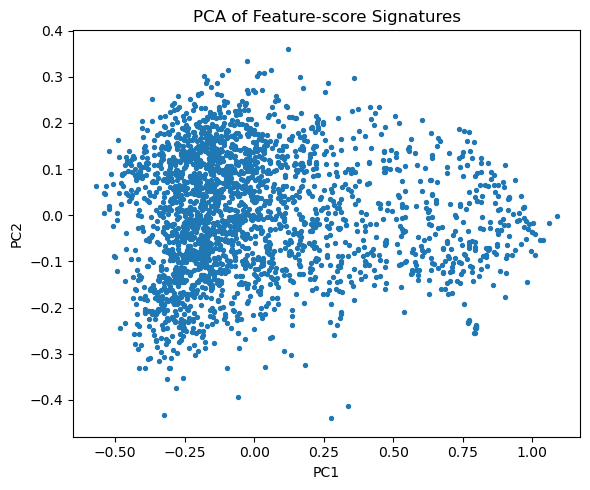

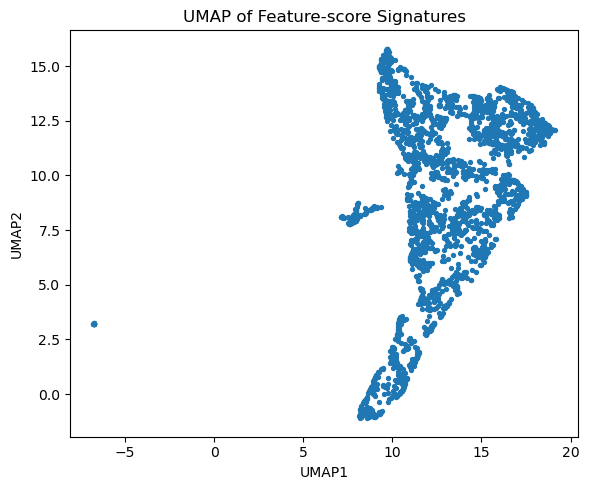

In [17]:
from sklearn.decomposition import PCA
import umap

# use normalized-score matrix for projection
S = df_results[[c+"_norm" for c in score_cols]].values

# PCA projection
pca2 = PCA(n_components=2).fit_transform(S)
plt.figure(figsize=(6,5))
plt.scatter(pca2[:,0], pca2[:,1], s=8)
plt.title("PCA of Feature‑score Signatures")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

# UMAP projection
u = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(S)
plt.figure(figsize=(6,5))
plt.scatter(u[:,0], u[:,1], s=8)
plt.title("UMAP of Feature‑score Signatures")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout(); plt.show()


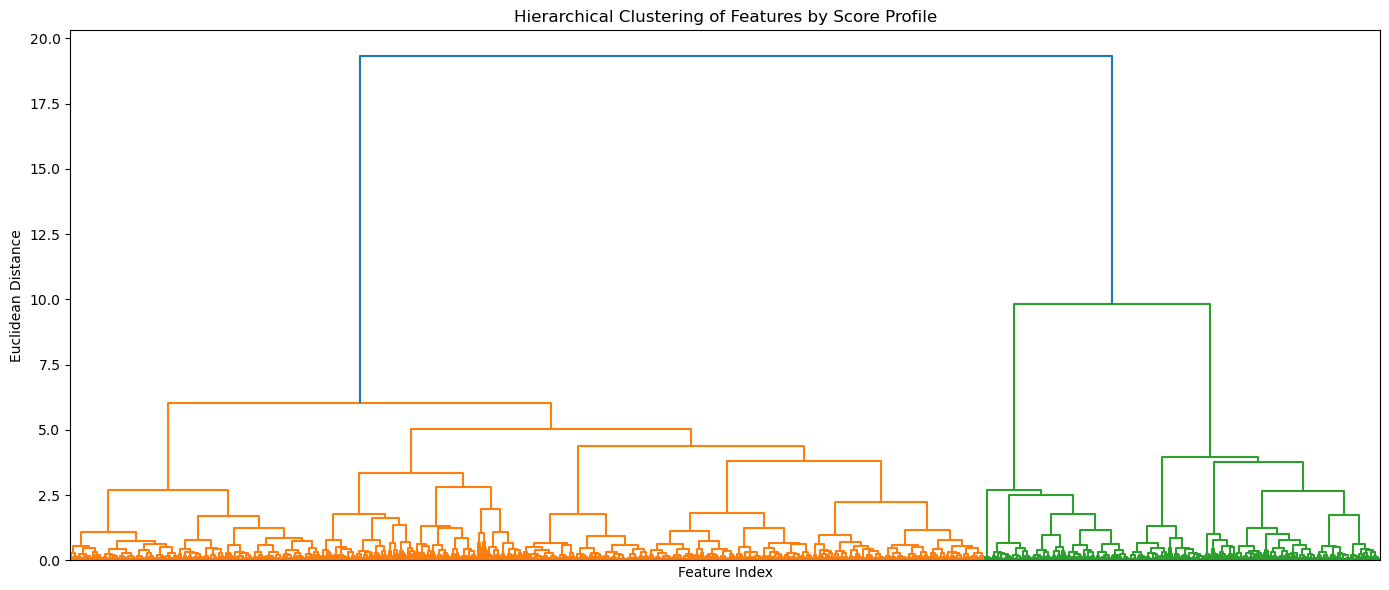

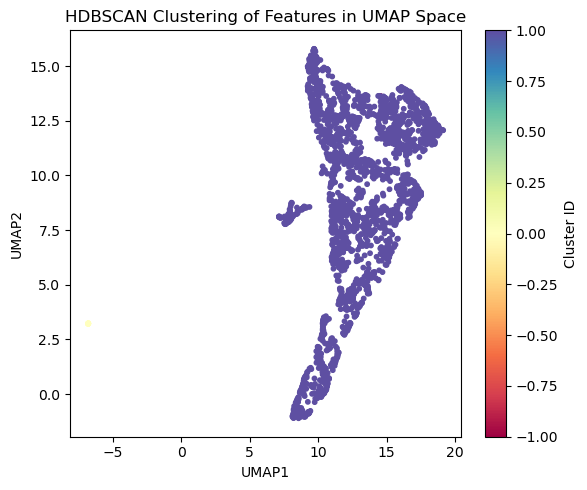

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
import hdbscan

# === 1. Build normalized score matrix (rows = features, columns = score types) ===
S = df_results[[f"{col}_norm" for col in score_cols]].values
feature_names = df_results["Feature"].values

# === 2. Hierarchical Clustering and Dendrogram ===
Z = linkage(S, method="ward")
plt.figure(figsize=(14, 6))
dendrogram(Z, labels=feature_names, leaf_rotation=90, leaf_font_size=6, no_labels=True)
plt.title("Hierarchical Clustering of Features by Score Profile")
plt.xlabel("Feature Index")
plt.ylabel("Euclidean Distance")
plt.tight_layout()
plt.show()

# Optional: Cut dendrogram into clusters
threshold = 1.2  # adjust this
labels_hier = fcluster(Z, t=threshold, criterion='distance')
df_results["HClust_Label"] = labels_hier

# === 3. HDBSCAN Clustering of Feature Behaviors ===
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, metric='euclidean')
labels_hdb = clusterer.fit_predict(S)

df_results["HDBSCAN_Label"] = labels_hdb

# Plot clusters in UMAP space (assuming u is your Step 6 UMAP projection)
plt.figure(figsize=(6, 5))
plt.scatter(u[:, 0], u[:, 1], c=labels_hdb, cmap="Spectral", s=10)
plt.title("HDBSCAN Clustering of Features in UMAP Space")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.colorbar(label="Cluster ID")
plt.tight_layout()
plt.show()


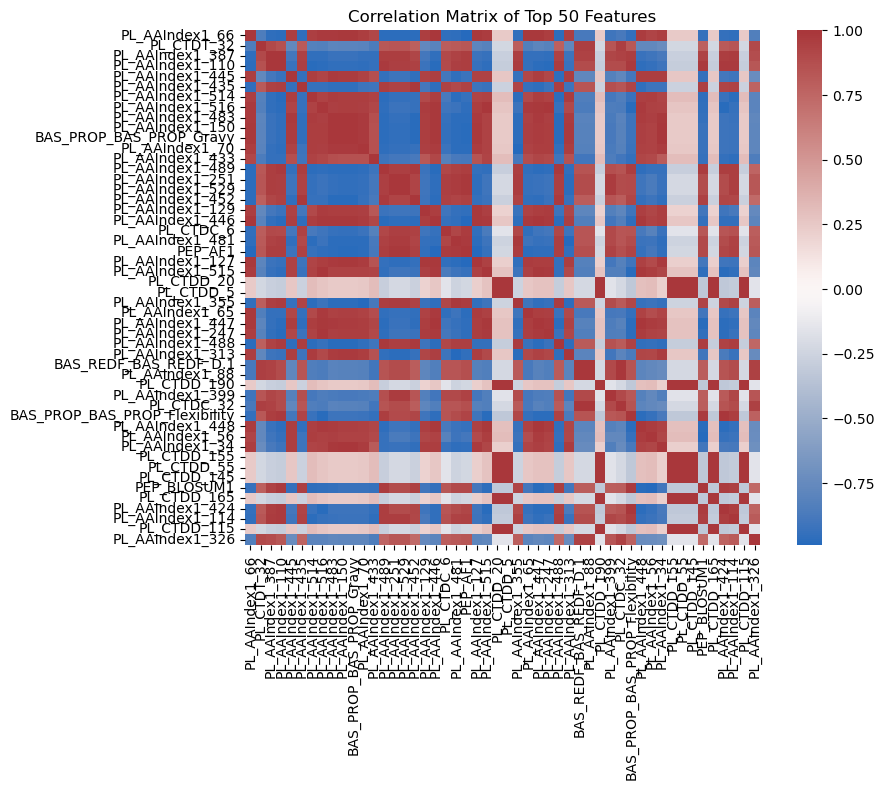

In [21]:
# Select top-k features (based on MeanScore or any other score)
top_features = df_results.sort_values("MeanScore", ascending=False).head(50)["Feature"].values

# Extract their actual values (scaled)
top_X = X_scaled[:, [X_all.columns.get_loc(f) for f in top_features]]

# Compute correlation matrix
corr = pd.DataFrame(top_X).corr()

# Visualize correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="vlag", center=0, square=True, xticklabels=top_features, yticklabels=top_features)
plt.title("Correlation Matrix of Top 50 Features")
plt.tight_layout()
plt.show()


## Step 7 – Optimal Feature Block Selection 

**Goal:**  
Identify the smallest, most synergistic combination of feature‑blocks that maximizes classification performance (AUC‑ROC) while penalizing model complexity (AIC/BIC). A multi‑pronged search strategy will be employed to leave no doubt that this is the best possible block grouping.

---

### 7.1 Evaluation Function  
A helper `evaluate_blocks(blocks)` that returns cross‑validated:  
- **AUC**  
- **Accuracy**  
- **Negative log‑loss**  
- **AIC/BIC** (penalizing number of features)

In [22]:
from typing import List, Dict, Any
from itertools import chain
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 5‑fold stratified CV for all block evaluations
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# total number of samples (for AIC/BIC)
N_SAMPLES = X_all.shape[0]

def evaluate_blocks(
    blocks: List[str],
    model: Any = None
) -> Dict[str, float]:
    """
    Evaluate a set of feature‐blocks via cross‐validated metrics and approximate AIC/BIC.

    Args:
        blocks: List of block names to include (keys in feature_registry).
        model: a scikit‐learn classifier; if None, defaults to RandomForestClassifier.

    Returns:
        A dict with:
        - 'auc':    mean ROC‑AUC (ovr)
        - 'acc':    mean accuracy
        - 'neg_logloss': mean negative log‐loss
        - 'aic':   Akaike Information Criterion (approx)
        - 'bic':   Bayesian Information Criterion (approx)
        - 'n_features': total number of features used
    """
    # default model if none provided
    if model is None:
        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

    # gather feature columns for the requested blocks
    feature_cols = list(chain.from_iterable(feature_registry[b] for b in blocks))
    X = X_all[feature_cols]
    y = y_encoded

    # cross‐validated metrics
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc_ovr", n_jobs=-1)
    acc_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy",    n_jobs=-1)
    negll_scores = cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs=-1)

    mean_auc      = np.mean(auc_scores)
    mean_acc      = np.mean(acc_scores)
    mean_negll    = np.mean(negll_scores)

    # approximate log‐likelihood over full data
    k = X.shape[1]  # number of parameters ~ number of features
    ll = - mean_negll * N_SAMPLES
    aic = 2 * k - 2 * ll
    bic = k * np.log(N_SAMPLES) - 2 * ll

    return {
        "auc":            mean_auc,
        "acc":            mean_acc,
        "neg_logloss":    mean_negll,
        "aic":            aic,
        "bic":            bic,
        "n_features":     k
    }


---

### 7.2 Greedy Forward Selection  
- Iteratively add the block that gives the highest increase in  
  **(AUC – λ · BIC)**  
- Stop when no further improvement is possible  
- Tracks per‑step metrics and final selected block list

In [31]:
# step_7_2_feature_selection.py

import numpy as np
from itertools import chain
from typing import List, Dict, Any, Tuple
from functools import lru_cache
from joblib import Parallel, delayed
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# ────────────────────────────────────────────────────────────────────────────────
# Assumptions: X_all (pd.DataFrame), y_encoded (np.ndarray), and
# feature_registry (Dict[str, List[str]]) are already defined in your namespace.
# ────────────────────────────────────────────────────────────────────────────────

# 5‑fold stratified CV and sample count for AIC/BIC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
N_SAMPLES = X_all.shape[0]

def evaluate_blocks(
    blocks: List[str],
    model: Any = None
) -> Dict[str, float]:
    """
    Step 7.1: Evaluate a set of feature‐blocks via CV metrics and approximate AIC/BIC.
    """
    # Default to a 100‑tree RF if no model is passed
    if model is None:
        model = RandomForestClassifier(
            n_estimators=100, n_jobs=-1, random_state=42
        )

    # Gather all feature columns for the requested blocks
    feature_cols = list(chain.from_iterable(feature_registry[b] for b in blocks))
    X = X_all[feature_cols]
    y = y_encoded

    # Compute CV scores
    auc_scores   = cross_val_score(model, X, y, cv=cv, scoring="roc_auc_ovr", n_jobs=-1)
    acc_scores   = cross_val_score(model, X, y, cv=cv, scoring="accuracy",    n_jobs=-1)
    negll_scores = cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs=-1)

    mean_auc   = np.mean(auc_scores)
    mean_acc   = np.mean(acc_scores)
    mean_negll = np.mean(negll_scores)

    # Approximate log‐likelihood
    k   = X.shape[1]
    ll  = - mean_negll * N_SAMPLES
    aic = 2 * k - 2 * ll
    bic = k * np.log(N_SAMPLES) - 2 * ll

    return {
        "auc":         mean_auc,
        "acc":         mean_acc,
        "neg_logloss": mean_negll,
        "aic":         aic,
        "bic":         bic,
        "n_features":  k
    }

# ────────────────────────────────────────────────────────────────────────────────
# Internal caching & parallel helpers
# ────────────────────────────────────────────────────────────────────────────────

@lru_cache(maxsize=None)
def _cached_eval(
    blocks_tuple: Tuple[str, ...],
    model_params_tuple: Tuple[Tuple[str, Any], ...]
) -> Dict[str, float]:
    """
    Cached wrapper around evaluate_blocks to avoid recomputing identical block sets.
    """
    rf_kwargs = dict(model_params_tuple)
    model = RandomForestClassifier(**rf_kwargs)
    return evaluate_blocks(list(blocks_tuple), model=model)

def _evaluate_candidate(
    block: str,
    selected_tuple: Tuple[str, ...],
    params_key: Tuple[Tuple[str, Any], ...],
    lam: float
) -> Tuple[str, float, Dict[str, Any]]:
    """
    Worker function for parallel evaluation: returns (block, objective, metrics).
    """
    candidate = list(selected_tuple) + [block]
    metrics = _cached_eval(tuple(candidate), params_key)
    obj = metrics["auc"] - lam * metrics["bic"]
    return block, obj, metrics

# ────────────────────────────────────────────────────────────────────────────────
# Step 7.2: Greedy Forward Selection with joblib threading
# ────────────────────────────────────────────────────────────────────────────────

def greedy_forward_selection(
    block_dict: Dict[str, List[str]],
    lam: float,
    model_params: Dict[str, Any]
) -> Tuple[List[str], List[Dict[str, Any]]]:
    """
    Greedy forward selection over feature blocks, maximizing AUC - lam*BIC.

    Args:
        block_dict:   Mapping of block names to feature columns.
        lam:          Penalty weight on BIC.
        model_params: RandomForestClassifier kwargs (must include 'n_jobs').
    Returns:
        selected:     Ordered list of selected blocks.
        history:      List of dicts with metrics + objective at each step.
    """
    if not block_dict:
        raise ValueError("`block_dict` must contain at least one block.")

    selected: List[str] = []
    remaining = list(block_dict.keys())
    history: List[Dict[str, Any]] = []
    best_obj = float("-inf")

    # Prepare cache key and thread count
    params_key = tuple(sorted(model_params.items()))
    n_jobs     = model_params.get("n_jobs", 1)

    while True:
        selected_tuple = tuple(selected)
        # Evaluate all remaining blocks in parallel threads
        results = Parallel(n_jobs=n_jobs, backend="threading")(
            delayed(_evaluate_candidate)(
                blk, selected_tuple, params_key, lam
            ) for blk in remaining
        )

        # Choose the block that maximizes the penalized objective
        round_best_block, round_best_obj, round_best_metrics = max(
            results, key=lambda x: x[1], default=("", best_obj, {})
        )

        # Stop if no improvement
        if not round_best_block or round_best_obj <= best_obj:
            break

        # Accept this block and record metrics
        selected.append(round_best_block)
        remaining.remove(round_best_block)
        best_obj = round_best_obj
        history.append({
            "selected":  selected.copy(),
            **round_best_metrics,
            "objective": best_obj
        })

    return selected, history

# ────────────────────────────────────────────────────────────────────────────────
# Step 7.2 (cont’d): Autotune λ via Optuna
# ────────────────────────────────────────────────────────────────────────────────

def tune_lambda_with_optuna(
    block_dict: Dict[str, List[str]],
    n_trials: int = 30,
    lam_bounds: Tuple[float, float] = (1e-5, 1e-2)
) -> float:
    """
    Autotune λ to maximize the greedy objective using a lightweight RandomForest.
    """
    # Lightweight RF config for tuning
    fast_rf_params = {
        "n_estimators": 30,
        "max_depth":    None,
        "n_jobs":       -1,
        "random_state": 42
    }

    def objective(trial: optuna.trial.Trial) -> float:
        lam = trial.suggest_loguniform("lam", lam_bounds[0], lam_bounds[1])
        _cached_eval.cache_clear()
        _, hist = greedy_forward_selection(block_dict, lam, fast_rf_params)
        if not hist:
            # Fallback to empty‐set evaluation
            m = evaluate_blocks([], model=RandomForestClassifier(**fast_rf_params))
            return m["auc"] - lam * m["bic"]
        return hist[-1]["objective"]

    study = optuna.create_study(
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
    )
    study.optimize(objective, n_trials=n_trials)
    return study.best_params["lam"]

# ────────────────────────────────────────────────────────────────────────────────
# Example usage
# ────────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # 1) Tune lambda
    tuned_lam = tune_lambda_with_optuna(
        block_dict=feature_registry,
        n_trials=30,
        lam_bounds=(1e-5, 1e-2)
    )
    print(f"Tuned λ = {tuned_lam:.3e}")

    # 2) Final greedy selection with full RF
    full_rf_params = {
        "n_estimators": 100,
        "max_depth":    None,
        "n_jobs":       -1,
        "random_state": 42
    }
    selected_blocks, selection_history = greedy_forward_selection(
        block_dict=feature_registry,
        lam=tuned_lam,
        model_params=full_rf_params
    )
    print("Selected blocks:", selected_blocks)

    # Optionally inspect history:
    # import pandas as pd
    # df_hist = pd.DataFrame(selection_history)
    # print(df_hist)


[I 2025-04-21 14:12:36,755] A new study created in memory with name: no-name-cd6d8150-af41-4818-ae46-aafdb380afe6
[I 2025-04-21 14:17:22,641] Trial 0 finished with value: 1.0881549949456657 and parameters: {'lam': 1.9911722105034282e-05}. Best is trial 0 with value: 1.0881549949456657.
[I 2025-04-21 14:20:56,108] Trial 1 finished with value: 5.288128988971908 and parameters: {'lam': 0.00018528616595540548}. Best is trial 1 with value: 5.288128988971908.
[I 2025-04-21 14:25:08,933] Trial 2 finished with value: 1.0419783793421369 and parameters: {'lam': 1.8093512722026786e-05}. Best is trial 1 with value: 5.288128988971908.
[I 2025-04-21 14:27:50,947] Trial 3 finished with value: 7.301607569932707 and parameters: {'lam': 0.00026456710936234844}. Best is trial 3 with value: 7.301607569932707.
[I 2025-04-21 14:29:52,078] Trial 4 finished with value: 3.0947929669787264 and parameters: {'lam': 9.892331577347134e-05}. Best is trial 3 with value: 7.301607569932707.
[I 2025-04-21 14:31:54,415] 

Tuned λ = 9.992e-03
Selected blocks: ['PL_Entropy']


---

### 7.3 Simulated Annealing / MCMC Search  
- Starts from the greedy solution  
- Proposes single‑block additions/removals  
- Accepts moves by Metropolis criterion on the **(AUC – λ · BIC)** objective  
- Returns the globally best subset found

In [32]:
# step_7_3_mcmc.py

import random
import math
from typing import List, Dict, Any, Callable, Tuple
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier

def mcmc_block_search(
    blocks: List[str],
    greedy_init: List[str],
    evaluate_fn: Callable[[List[str], Any], Dict[str, float]],
    iterations: int = 300,
    T0: float = 1.0,
    cooling_rate: float = 0.995,
    lam: float = 1e-3,
    model: Any = None,
    verbose: bool = True
) -> Tuple[List[str], Dict[str, Any], List[Dict[str, Any]]]:
    """
    Step 7.3: Simulated Annealing (MCMC) for block subset selection,
    optimizing objective = AUC - λ * BIC.

    Args:
        blocks:       List of all block names.
        greedy_init:  Initial block subset (from Step 7.2 greedy output).
        evaluate_fn:  Callable(subset, model) -> dict with keys 'auc' and 'bic'.
        iterations:   Number of MCMC iterations.
        T0:           Initial temperature.
        cooling_rate: Temperature decay per iteration.
        lam:          Penalty weight on BIC.
        model:        Optional sklearn classifier (default = RandomForest(100)).
        verbose:      Print progress every 10 steps.

    Returns:
        best_subset: Block list with highest objective found.
        best_metrics: dict of evaluation metrics for best_subset.
        trajectory: list of dicts recording each iteration’s state.
    """
    # Default model
    if model is None:
        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

    def objective(m: Dict[str, float]) -> float:
        return m["auc"] - lam * m["bic"]

    # Cache to avoid re-evaluations
    cache: Dict[tuple, Dict[str, float]] = {}
    def get_metrics(subset: List[str]) -> Dict[str, float]:
        key = tuple(sorted(subset))
        if key not in cache:
            cache[key] = evaluate_fn(subset, model)
        return cache[key]

    # Initialize chain
    current = greedy_init.copy() or [random.choice(blocks)]
    curr_met = get_metrics(current)
    curr_score = objective(curr_met)

    best = current.copy()
    best_met = curr_met.copy()
    best_score = curr_score

    T = T0
    accepted = 0
    trajectory: List[Dict[str, Any]] = []

    if verbose:
        print(f"[Init] AUC={curr_met['auc']:.4f}, BIC={curr_met['bic']:.2f}, Score={curr_score:.4f}")

    for i in tqdm(range(iterations), desc="MCMC Simulated Annealing"):
        prop = current.copy()

        # Propose a move: add or remove one block
        if len(prop) > 1 and random.random() < 0.5:
            prop.remove(random.choice(prop))
        else:
            candidates = [b for b in blocks if b not in prop]
            if candidates:
                prop.append(random.choice(candidates))
            else:
                prop.remove(random.choice(prop))

        # Prevent empty subset
        if not prop:
            prop = [random.choice(blocks)]

        met = get_metrics(prop)
        score = objective(met)
        delta = score - curr_score

        accepted_step = False
        if delta > 0 or random.random() < math.exp(delta / T):
            current = prop
            curr_score = score
            curr_met = met
            accepted += 1
            accepted_step = True

        if curr_score > best_score:
            best = current.copy()
            best_score = curr_score
            best_met = curr_met.copy()

        trajectory.append({
            "iteration": i,
            "temperature": T,
            "accepted": accepted_step,
            "score": curr_score,
            "auc": curr_met["auc"],
            "bic": curr_met["bic"],
            "subset": current.copy()
        })

        if verbose and i % 10 == 0:
            print(f"[Step {i}] Score={curr_score:.4f}, Blocks={len(current)}, Accepted={accepted}")

        T = max(T * cooling_rate, 1e-6)

    if verbose:
        print(f"\n[Done] Best Score={best_score:.4f} with {len(best)} blocks.")
        print(f"Best AUC={best_met['auc']:.4f}, Best BIC={best_met['bic']:.2f}")

    return best, best_met, trajectory


if __name__ == "__main__":
    # Example usage:

    # 1. List of all registered blocks
    all_blocks = list(feature_registry.keys())

    # 2. Greedy initialization from Step 7.2
    greedy_selected = selected_blocks  # obtained from greedy_forward_selection()

    # 3. Tuned lambda from Step 7.2 Optuna
    tuned_lam = 0.009991894891747078

    # 4. Run MCMC search
    mcmc_sel, mcmc_metrics, mcmc_traj = mcmc_block_search(
        blocks=all_blocks,
        greedy_init=greedy_selected,
        evaluate_fn=evaluate_blocks,
        iterations=300,
        T0=1.0,
        cooling_rate=0.995,
        lam=tuned_lam,
        verbose=True
    )

    print("MCMC Best Subset:", mcmc_sel)
    print("MCMC Metrics:", mcmc_metrics)


[Init] AUC=0.5941, BIC=-21911.89, Score=219.5354


MCMC Simulated Annealing:   0%|          | 0/300 [00:00<?, ?it/s]

[Step 0] Score=219.5354, Blocks=1, Accepted=0
[Step 10] Score=219.5354, Blocks=1, Accepted=0
[Step 20] Score=219.5354, Blocks=1, Accepted=0
[Step 30] Score=219.5354, Blocks=1, Accepted=0
[Step 40] Score=219.5354, Blocks=1, Accepted=0
[Step 50] Score=219.5354, Blocks=1, Accepted=0
[Step 60] Score=219.5354, Blocks=1, Accepted=0
[Step 70] Score=219.5354, Blocks=1, Accepted=0
[Step 80] Score=219.5354, Blocks=1, Accepted=0
[Step 90] Score=219.5354, Blocks=1, Accepted=0
[Step 100] Score=219.5354, Blocks=1, Accepted=0
[Step 110] Score=219.5354, Blocks=1, Accepted=0
[Step 120] Score=219.5354, Blocks=1, Accepted=0
[Step 130] Score=219.5354, Blocks=1, Accepted=0
[Step 140] Score=219.5354, Blocks=1, Accepted=0
[Step 150] Score=219.5354, Blocks=1, Accepted=0
[Step 160] Score=219.5354, Blocks=1, Accepted=0
[Step 170] Score=219.5354, Blocks=1, Accepted=0
[Step 180] Score=219.5354, Blocks=1, Accepted=0
[Step 190] Score=219.5354, Blocks=1, Accepted=0
[Step 200] Score=219.5354, Blocks=1, Accepted=0
[St

---

### 7.4 Gaussian Mixture Clustering on Block Signatures  
- For each block, build a 5‑dim signature: [AUC, ACC, neg_logloss, AIC, BIC]  
- Fit a GMM to group blocks with similar performance profiles  
- Propose each cluster as a “meta‑block” for second‑pass selection

---

### 7.5 (Advanced) Graph Neural Network for Synergy  
- Build a block‑pair synergy graph (edge weight = ΔAUC when both blocks are used)  
- Train a small GCN to predict per‑block importance from that graph  
- Outputs a learned ranking of blocks capturing higher‑order interactions

---

### 7.6 (Advanced) Variational Autoencoder for Latent Block Discovery  
- Encode each block’s performance signature into a low‑dim latent space  
- Decode latent coordinates back to synthetic signatures  
- Cluster latent embeddings to propose new, nonlinear block groupings